## Voxel VLMap Creation

In [70]:
import os
import torch
data_dir = r"C:\Users\Andrew Jeon\OneDrive\Desktop\vlmaps\data\5LpN3gDmAk7_1"
root_dir = r"C:\Users\Andrew Jeon\OneDrive\Desktop\vlmaps"
colors_path = root_dir + "/maps/colormap.npy"
features_path = root_dir + "/maps/featuremap.npy"
coordinates_path = root_dir + "/maps/coordinates.npy"

In [71]:
# setup parameters
# @markdown meters per cell size
cs = 0.05 # @param {type: "number"}
voxel_size = 0.05 # @param {type: "number"}
# @markdown map resolution (gs x gs)
gs = 1000 # @param {type: "integer"}
# @markdown camera height (used for filtering out points on the floor)
camera_height = 1.5 # @param {type: "number"}
# @markdown depth pixels subsample rate
depth_sample_rate = 100 # @param {type: "integer"}
# @markdown data where rgb, depth, pose are loaded and map are saved
data_dir = data_dir # @param {type: "string"}

img_save_dir = data_dir
mask_version = 1
crop_size = 480 # 480
base_size = 520 # 520

## Load Model

In [72]:
import open3d
import clip
# import torch
lang = "door,chair,ground,ceiling,other"
labels = lang.split(",")

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_version = "ViT-B/32"
clip_feat_dim = {'RN50': 1024, 'RN101': 512, 'RN50x4': 640, 'RN50x16': 768,
                'RN50x64': 1024, 'ViT-B/32': 512, 'ViT-B/16': 512, 'ViT-L/14': 768}[clip_version]

print("Loading CLIP model...")
clip_model, preprocess = clip.load(clip_version, device=device)  # clip.available_models()

clip_model.to(device).eval()


Loading CLIP model...


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [73]:
import numpy as np
import cv2
import math
# import open3d

from tqdm import tqdm

from utils.clip_mapping_utils import load_pose, load_semantic, load_obj2cls_dict, save_map, cvt_obj_id_2_cls_id, depth2pc, transform_pc, get_sim_cam_mat, pos2grid_id, project_point
from lseg.modules.models.lseg_net import LSegEncNet
from lseg.additional_utils.models import resize_image, pad_image, crop_image

In [74]:
import torch
import torchvision.transforms as transforms
from lseg.modules.models.lseg_net import LSegEncNet

lang_token = clip.tokenize(labels)
lang_token = lang_token.to(device)
with torch.no_grad():
    text_feats = clip_model.encode_text(lang_token)
    text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)
text_feats = text_feats.cpu().numpy()
model = LSegEncNet(lang, arch_option=0,
                    block_depth=0,
                    activation='lrelu',
                    crop_size=crop_size)
model_state_dict = model.state_dict()
print("Loading Checkpoints...")
if device == "cpu":
    pretrained_state_dict = torch.load("lseg/checkpoints/demo_e200.ckpt", map_location=torch.device('cpu'))
else:
    pretrained_state_dict = torch.load("lseg/checkpoints/demo_e200.ckpt")
pretrained_state_dict = {k.lstrip('net.'): v for k, v in pretrained_state_dict['state_dict'].items()}
model_state_dict.update(pretrained_state_dict)
model.load_state_dict(pretrained_state_dict)

model.eval()
if device == "cuda":
    model = model.cuda()

norm_mean= [0.5, 0.5, 0.5]
norm_std = [0.5, 0.5, 0.5]
padding = [0.0] * 3
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

Loading Checkpoints...


## Create Map

In [75]:
# This thing outputs a image segmentation mask as a np array
def get_lseg_feat(model: LSegEncNet, image: np.array, labels, transform, crop_size=480, \
                 base_size=520, norm_mean=[0.5, 0.5, 0.5], norm_std=[0.5, 0.5, 0.5]):
    vis_image = image.copy()
    if device == "cpu":
        image = transform(image).unsqueeze(0)
    else:
        image = transform(image).unsqueeze(0).cuda()
    img = image[0].permute(1,2,0)
    img = img * 0.5 + 0.5
    
    batch, _, h, w = image.size() # batch is dimension 1, ignoring channel, y, x
    stride_rate = 2.0/3.0
    stride = int(crop_size * stride_rate)

    long_size = base_size
    if h > w:
        height = long_size
        width = int(1.0 * w * long_size / h + 0.5)
        short_size = width
    else:
        width = long_size
        height = int(1.0 * h * long_size / w + 0.5)
        short_size = height


    cur_img = resize_image(image, height, width, **{'mode': 'bilinear', 'align_corners': True})

    if long_size <= crop_size:
        pad_img = pad_image(cur_img, norm_mean,
                            norm_std, crop_size)
        print(pad_img.shape)
        with torch.no_grad():
            outputs, logits = model(pad_img, labels)
        outputs = crop_image(outputs, 0, height, 0, width)
    else:
        if short_size < crop_size:
            # pad if needed
            pad_img = pad_image(cur_img, norm_mean,
                                norm_std, crop_size)
        else:
            pad_img = cur_img
        _,_,ph,pw = pad_img.shape #.size()
        assert(ph >= height and pw >= width)
        h_grids = int(math.ceil(1.0 * (ph-crop_size)/stride)) + 1
        w_grids = int(math.ceil(1.0 * (pw-crop_size)/stride)) + 1

        if device == "cpu":
            with torch.cuda.device_of(image):
                with torch.no_grad():
                    outputs = image.new().resize_(batch, model.out_c,ph,pw).zero_()
                    logits_outputs = image.new().resize_(batch, len(labels),ph,pw).zero_()
                count_norm = image.new().resize_(batch,1,ph,pw).zero_()
        else:
            with torch.cuda.device_of(image):
                with torch.no_grad():
                    outputs = image.new().resize_(batch, model.out_c,ph,pw).zero_().cuda()
                    logits_outputs = image.new().resize_(batch, len(labels),ph,pw).zero_().cuda()
                count_norm = image.new().resize_(batch,1,ph,pw).zero_().cuda()
        # grid evaluation
        for idh in range(h_grids):
            for idw in range(w_grids):
                h0 = idh * stride
                w0 = idw * stride
                h1 = min(h0 + crop_size, ph)
                w1 = min(w0 + crop_size, pw)
                crop_img = crop_image(pad_img, h0, h1, w0, w1)
                # pad if needed
                pad_crop_img = pad_image(crop_img, norm_mean,
                                            norm_std, crop_size)
                with torch.no_grad():
                    output, logits = model(pad_crop_img, labels)
                cropped = crop_image(output, 0, h1-h0, 0, w1-w0)
                cropped_logits = crop_image(logits, 0, h1-h0, 0, w1-w0)
                outputs[:,:,h0:h1,w0:w1] += cropped
                logits_outputs[:,:,h0:h1,w0:w1] += cropped_logits
                count_norm[:,:,h0:h1,w0:w1] += 1
        assert((count_norm==0).sum()==0)
        outputs = outputs / count_norm
        logits_outputs = logits_outputs / count_norm
        outputs = outputs[:,:,:height,:width]
        logits_outputs = logits_outputs[:,:,:height,:width]
    outputs = outputs.cpu()
    outputs = outputs.numpy() # B, D, H, W
    predicts = [torch.max(logit, 0)[1].cpu().numpy() for logit in logits_outputs]
    pred = predicts[0]

    return outputs

def load_depth(depth_filepath):
    with open(depth_filepath, 'rb') as f:
        depth = np.load(f)
    return depth

In [76]:
print(f"loading scene {img_save_dir}")
rgb_dir = os.path.join(img_save_dir, "rgb")
depth_dir = os.path.join(img_save_dir, "depth")
pose_dir = os.path.join(img_save_dir, "pose")
semantic_dir = os.path.join(img_save_dir, "semantic")

rgb_list = sorted(os.listdir(rgb_dir), key=lambda x: int(
    x.split("_")[-1].split(".")[0]))
depth_list = sorted(os.listdir(depth_dir), key=lambda x: int(
    x.split("_")[-1].split(".")[0]))
pose_list = sorted(os.listdir(pose_dir), key=lambda x: int(
    x.split("_")[-1].split(".")[0]))
# pose_list = sorted(os.listdir(pose_dir), key=lambda x: int(
#     x.split("_")[-1].split(".")[0]))
semantic_list = sorted(os.listdir(semantic_dir), key=lambda x: int(
    x.split("_")[-1].split(".")[0]))

rgb_list = [os.path.join(rgb_dir, x) for x in rgb_list]
depth_list = [os.path.join(depth_dir, x) for x in depth_list]
pose_list = [os.path.join(pose_dir, x) for x in pose_list]
semantic_list = [os.path.join(semantic_dir, x) for x in semantic_list]

tf_list = []
data_iter = zip(rgb_list, depth_list, semantic_list, pose_list)
len(rgb_list)

loading scene C:\Users\Andrew Jeon\OneDrive\Desktop\vlmaps\data\5LpN3gDmAk7_1


1159

In [77]:
pos, rot = load_pose(pose_list[1])
rot_ro_cam = np.eye(3)
rot_ro_cam[1, 1] = -1
rot_ro_cam[2, 2] = -1
rot = rot @ rot_ro_cam
pos[1] += camera_height

pose = np.eye(4)
pose[:3, :3] = rot
pose[:3, 3] = pos.reshape(-1)

tf_list.append(pose)
if len(tf_list) == 1:
    init_tf_inv = np.linalg.inv(tf_list[0]) 

tf = init_tf_inv @ pose
p = 1

In [78]:
depth = load_depth(depth_list[0])
pc, mask = depth2pc(depth)

In [ ]:
from utils.voxel import Voxel, GetVoxelCoor

# lang = "door,chair,ground,ceiling,other"
lang = "ground,other"
labels = lang.split(",")

voxel_grid = {}

for frame_index, data_sample in enumerate(data_iter): 
    # print(frame_index)   
    rgb_path, depth_path, semantic_path, pose_path = data_sample
    
    bgr = cv2.imread(rgb_path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    # read pose
    pos, rot = load_pose(pose_path)  # z backward, y upward, x to the right
    rot_ro_cam = np.eye(3)
    rot_ro_cam[1, 1] = -1
    rot_ro_cam[2, 2] = -1
    rot = rot @ rot_ro_cam
    pos[1] += camera_height

    pose = np.eye(4)
    pose[:3, :3] = rot
    pose[:3, 3] = pos.reshape(-1)

    tf_list.append(pose)
    if len(tf_list) == 1:
        init_tf_inv = np.linalg.inv(tf_list[0]) 

    tf = init_tf_inv @ pose

    depth = load_depth(depth_path)
    
    # transform all points to the global frame
    pc, mask = depth2pc(depth)
    shuffle_mask = np.arange(pc.shape[1]) 
    np.random.shuffle(shuffle_mask)
    shuffle_mask = shuffle_mask[::depth_sample_rate]
    mask = mask[shuffle_mask]
    pc = pc[:, shuffle_mask]
    pc = pc[:, mask]
    pc_global = transform_pc(pc, tf)

    pix_feats = get_lseg_feat(model, rgb, labels, transform, crop_size, base_size, norm_mean, norm_std)

    rgb_cam_mat = get_sim_cam_mat(rgb.shape[0], rgb.shape[1])
    feat_cam_mat = get_sim_cam_mat(pix_feats.shape[2], pix_feats.shape[3])

    for pixel_index, (p, p_local) in enumerate(zip(pc_global.T, pc.T)):

        single_global_point = (tf @ np.vstack([p_local.reshape(3,1), np.ones((1, 1))]) )[:3]

        rgb_px, rgb_py, rgb_pz = project_point(rgb_cam_mat, p_local)
        rgb_v = rgb[rgb_py, rgb_px, :].reshape(1,3)

        voxel_coor = GetVoxelCoor(single_global_point, voxel_size)
        voxel_key = str(voxel_coor[0,0]) + "," + str(voxel_coor[1,0]) + "," + str(voxel_coor[2,0])
        if voxel_key not in voxel_grid:
            voxel_grid[voxel_key] = Voxel(voxel_coor, pix_feats.shape[1]) #if not in voxel grid, then make it
        voxel_grid[voxel_key].update_color((rgb_v/ 255.0))
         
        px, py, pz = project_point(feat_cam_mat, p_local)
        if not (px < 0 or py < 0 or px >= pix_feats.shape[3] or py >= pix_feats.shape[2]):
            feat = pix_feats[0, :, py, px] #these are for finding the corresponding features for that pixel in the feature matrix
            voxel_grid[voxel_key].update_feature(feat)

In [ ]:
save_map(colors_path, np.array([i.colors for i in voxel_grid.values()]))
save_map(features_path, np.array([i.features for i in voxel_grid.values()]))
save_map(coordinates_path, np.array([i.coordinates for i in voxel_grid.values()]))

AttributeError: 'open3d.cpu.pybind.geometry.VoxelGrid' object has no attribute 'values'

## Load Map from object

In [ ]:
from utils.clip_mapping_utils import load_map
from utils.clip_utils import get_text_feats
from utils.mp3dcat import mp3dcat
import numpy as np

colors = np.array([i.colors for i in voxel_grid.values()])
features = np.array([i.features for i in voxel_grid.values()])
coordinates = np.array([i.coordinates for i in voxel_grid.values()])

print(colors.shape)
print(features.shape)
print(coordinates.shape)

AttributeError: 'open3d.cpu.pybind.geometry.VoxelGrid' object has no attribute 'values'

## Load Map from directory

In [ ]:
from utils.clip_mapping_utils import load_map
from utils.clip_utils import get_text_feats
from utils.mp3dcat import mp3dcat
import numpy as np

colors = torch.tensor(load_map(colors_path))
features = torch.tensor(load_map(features_path), dtype=torch.float32)
coordinates = torch.tensor(load_map(coordinates_path), dtype=torch.int)

print(colors.shape)
print(features.shape)
print(coordinates.shape)

torch.Size([456992, 1, 3])
torch.Size([456992, 512])
torch.Size([456992, 3, 1])


## Averaging

In [ ]:
min_v, _ = torch.min(coordinates, dim=0)

coordinates = coordinates - min_v

max_v, _ = torch.max(coordinates, dim=0)
max_v += 1

grid = torch.zeros((max_v[0]+1, max_v[1]+1, max_v[2]+1, 1), dtype=torch.int32)

for i, coor in enumerate(coordinates):
    grid[coor[0], coor[1], coor[2]] = i

kernel_size = 3

new_coord = np.zeros((features.shape[0],3))
new_feat = np.zeros((features.shape))

index = 0
kernel_bound = int(kernel_size/2)
for x in tqdm(range(grid.shape[0]-kernel_bound)):
    for y in range(grid.shape[1]-kernel_bound):
        for z in range(grid.shape[2]-kernel_bound):
            if(grid[x,y,z] == 0):
                continue
            lower_x = 0 if x == 0 else x - kernel_bound
            lower_y = 0 if y == 0 else y - kernel_bound
            lower_z = 0 if z == 0 else z - kernel_bound
            voxel_patch = grid[lower_x:x+kernel_bound+1, lower_y:y+kernel_bound+1, lower_z:z+kernel_bound+1]
            voxel_patch_feat = features[voxel_patch.flatten()[voxel_patch.flatten() != 0]]

            new_feat[index] = torch.mean(voxel_patch_feat, dim=0)
            new_coord[index] = [x,y,z]
            index += 1

100%|██████████| 399/399 [05:02<00:00,  1.32it/s]


In [ ]:
lang = "wall, floor, chair, door, table, picture, cabinet, cushion, window, sofa, bed, curtain, plant, sink, stairs, ceiling"
# lang = mp3dcat
lang = lang.split(",")
text_feats = get_text_feats(lang, clip_model, clip_feat_dim)

scores_list = new_feat @ text_feats.T

predicts = np.argmax(scores_list, axis=1)

In [ ]:
# lang = "sofa, plant, towel, sink, food, other"
lang = "sofa, ceiling, cushion, floor, other"
lang = lang.split(",")
text_feats = get_text_feats(lang, clip_model, clip_feat_dim)

scores_list = features @ text_feats.T

predicts = np.argmax(scores_list, axis=1)

In [ ]:
lang = mp3dcat # lang is all the matterport classes
text_feats = get_text_feats(lang, clip_model, clip_feat_dim)

scores_list = features @ text_feats.T

predicts = np.argmax(scores_list, axis=1)

## Segment Colors

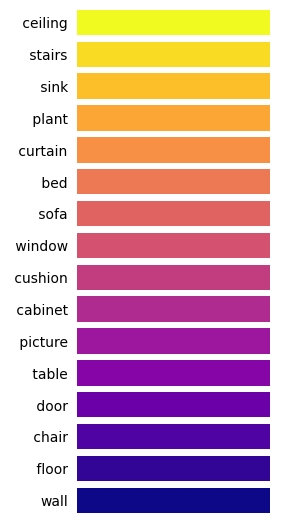

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

num_categories = len(lang)

# Choose a colormap (e.g., inferno, plasma, viridis)
cmap = cm.plasma

# Generate an array of values from 0 to 1 representing the colormap index
values = np.linspace(0, 1, num_categories)

# Get RGB colors from the colormap for each value
color_palette = cmap(values)[:,0:3]

# round colors
color_palette = np.round(color_palette, 2)

plt.figure(figsize=(3,num_categories/3))
bars = plt.barh(lang, [1 for i in range(num_categories)], color=color_palette)

plt.gca().xaxis.set_visible(False)
plt.margins(y=0.0)
plt.box(False)
plt.tick_params(left=False)
plt.tight_layout()
plt.show()

## Create Segmented Voxel Grid

In [ ]:
from utils.open3d import create_voxel

voxel_grid = create_voxel(coordinates, predicts, color_palette)

In [ ]:
from utils.open3d import create_voxel

voxel_grid = create_voxel(new_coord, predicts, color_palette)

## Create Real Voxel Grid

In [ ]:
from utils.open3d import create_real_rgb_voxel

voxel_grid = create_real_rgb_voxel(coordinates, colors)

## Display Voxel Grid

In [ ]:
from utils.open3d import visualize_map

visualize_map(voxel_grid)

running visualization
